# Probabalistic Road Map

Author: Michael Greer

This notebook implements a randomly sampled roadmap that can be used for robotic path planning

Probabalistic Road Maps (PRMs) and other probabalistic path planning methods like RRT are known as asymptotically complete planners. This means that given an infinite amount of time, these methods will be able to find an optimal path through the configuration space of a robotic system. Since we often don't have infinite time to plan, these methods are often used to quickly find a sub-optimal path through the space.These methods are very commonly used for pick-and-place tasks where the start and end configurations are fixed, but the path between them is not constrained except for by collision avoidance.

For simplicity, the configuration space in this document will be a linear 2D space with circular obstacles. This could be compared to something like a robot vacuum trying to navigate in a room with a bunch of circular chairs. In some cases, the roadmap is sampled with an awareness of the obstacles in the environment. In this case, the roadmap samples the space and edges are then enabled or disabled depending on the presence of obstacles. This method allows us to adapt to a changing environment; in our robot vacuum analogy, this could be a person walking through the workspace. This takes longer on a traditional computer, but researchers have had success speeding this up on custom hardware. 

Once the roadmap is constructed, any path finding algorithm suitable for graphs can be run to find the path. This implementation uses A*, but other implementations have employed the Bellman-Ford algorithm on custom hardware.

In [43]:
import numpy as np
from numpy import pi

import matplotlib.pyplot as plt

from scipy.spatial import Delaunay

In [44]:
# Borrowed from the collision avoidance notebook
class Circle:
    
    radius = 0
    center = 0
    
    def __init__(self, center, radius):
        
        self.center = center
        self.radius = radius
        
        return
    
    # Returns the distance from a point to a circle
    def distance(self, point):
        
        return np.linalg.norm(point - self.center) - self.radius
    
    # Returns the distance between a line and a circle
    # Line segment runs between l1 and l2
    def line_distance(self, l1, l2):
                
        # find closest distance between line and center of the circle
        length_squared = (l2 - l1) @ (l2 - l1)
        
        t = max(0, min(1, (self.center - l1) @ (l2 - l1) / length_squared))
        
        line_point = l1 + t * (l2 - l1)
        
        distance = np.linalg.norm(line_point - self.center)
                
        return distance - self.radius
    
    
class PRM:
        
    def __init__(self, size):
        
        self.vertices = np.zeros((2,size))
        self.edges = np.zeros((size,size))
        
        self.vertices_active = np.ones((size,))
        self.edges_active = np.ones((size,size))
        
        self.obstacles = []
        
        self.size = size
        
        return
        
    # Generates a set of random vertices
    # Connnects the vertices according to a Delaunay triangluation
    def generate(self):
        
        for i in range(0, self.size):
            
            self.vertices[:,i] = np.random.uniform(-5, 5, 2).T
            
        tri = Delaunay(self.vertices.T)
                
        for i in range(tri.simplices.shape[0]):
            
            self.edges[tri.simplices[i, 0], tri.simplices[i, 1]] = 1
            self.edges[tri.simplices[i, 1], tri.simplices[i, 0]] = 1
            
            self.edges[tri.simplices[i, 0], tri.simplices[i, 2]] = 1
            self.edges[tri.simplices[i, 2], tri.simplices[i, 0]] = 1
            
            self.edges[tri.simplices[i, 2], tri.simplices[i, 1]] = 1
            self.edges[tri.simplices[i, 1], tri.simplices[i, 2]] = 1
            
                    
        return
    
    # Plots the map and obstacles
    def plot(self, path=None, start=None, end=None):
        
        fig, ax = plt.subplots()

        ax.set_aspect( 1 )
        ax.set_xlim((-6,6))
        ax.set_ylim((-6,6))

        fig.set_figheight(15)
        fig.set_figwidth(15)
        
        for obs in self.obstacles:
    
            circle = plt.Circle(obs.center, obs.radius, color='y', fill=True)
            ax.add_artist(circle)

        # Draw vertices
        #plt.scatter(self.vertices[0,:], self.vertices[1,:])
        
        # Draw edges
        for i in range(0, self.size):
            
            for j in range(i+1, self.size):
                
                if (self.edges[i,j] == 1):
                    
                    if (self.edges_active[i,j] == 1):
                    
                        plt.plot([self.vertices[0,i], self.vertices[0,j]], [self.vertices[1,i], self.vertices[1,j]], 'b')

        
                    else:
        
                        plt.plot([self.vertices[0,i], self.vertices[0,j]], [self.vertices[1,i], self.vertices[1,j]], 'r')
        
        if (path != None):
                        
            verts = self.vertices[:,np.array(path).astype(int)]
                        
            plt.plot(verts[0,:], verts[1,:], 'g', linewidth=5.0)
            
        if (start != None):
            
            plt.scatter(self.vertices[0,start], self.vertices[1,start], 150, color='g')
            
        if (end != None):
            
            plt.scatter(self.vertices[0,end], self.vertices[1,end], 150, color='g')
        
        plt.show()

        
        return
    
    # Resets the active flags to all be true
    # Deletes all obstacle data
    def reset_obstacles(self):
        
        self.vertices_active = np.ones((self.size,))
        self.edges_active = np.ones((self.size,self.size))
        self.obstacles = []
        
    
    # Inserts a new obstacle into the space and checks for collision with nodes and edges
    def insert_obstacle(self, circle):
        
        self.obstacles.append(circle)
        
        for i in range(0, self.size):
            
            if (self.vertices_active[i] == 0): continue
            
            if (circle.distance(self.vertices[:,i]) < 0):
                
                self.vertices_active[i] = 0
                
                self.edges_active[:,i] = np.zeros((self.size,))
                self.edges_active[i,:] = np.zeros((self.size,)).T
                
        for i in range(0, self.size):
            
            for j in range(i+1, self.size):
                
                if (self.edges_active[i,j] == 0 or self.vertices_active[i] == 0 or self.vertices_active[j] == 0): continue
                
                if (circle.line_distance(self.vertices[:,i], self.vertices[:,j]) < 0):
                    
                    self.edges_active[i,j] = 0
                    self.edges_active[j,i] = 0
                
        return
    
    
    # Takes in the start and end points as indices
    # Uses the A* pathfinding algorithm
    def find_path(self, start, end):
            
        h = np.ones((self.size,)) * 1e15
        g = np.ones((self.size,)) * 1e15
        
        parents = np.ones((self.size,)) * -1
        
        v_closed = np.zeros((self.size,))
        
        g[start] = 0
        h[start] = np.linalg.norm(self.vertices[:,start] - self.vertices[:,end])
        
        while(True):
            
            if (np.all(h == 1e15)): return None
            
            f = h + g
            
            index = int(np.argmin(f))
            
            if (index == end): break
            
            for i in range(self.size):
                
                # Check if the vertices are connected, the connection is active, and the node is not closed
                if (self.edges[index, i] == 1 and self.edges_active[index, i] and v_closed[i] == 0):
                    
                    if (np.linalg.norm(self.vertices[:,i] - self.vertices[:,index]) + g[index] < g[i]):
                        
                        g[i] = np.linalg.norm(self.vertices[:,i] - self.vertices[:,index]) + g[index]
                        
                        parents[i] = index
                        
                        h[i] = np.linalg.norm(self.vertices[:,i] - self.vertices[:,end])
                        
            v_closed[index] = 1
            h[index] = 1e15
                                    
        path = [end]
                
        while(True):
                        
            path.append(parents[int(path[-1])])
            
            if (path[-1] == start): break
                        
        return path  
                        
                        
                        
                        
                        

In the plot below, the blue lines are edges that are joining different configurations. The red lines are edges that are in collision with some obstacle, and the obstacles themselves are shown in yellow.

In [54]:
wsmap = PRM(500)

wsmap.generate()

for i in range(15):
    wsmap.insert_obstacle(Circle(np.random.uniform(-4, 4, 2), np.random.uniform(0.5, 1.5)))

wsmap.plot()

Now that the map is constructed, we can query it to find paths through the space. The following code does this to find a path from the bottom left to top right corner.

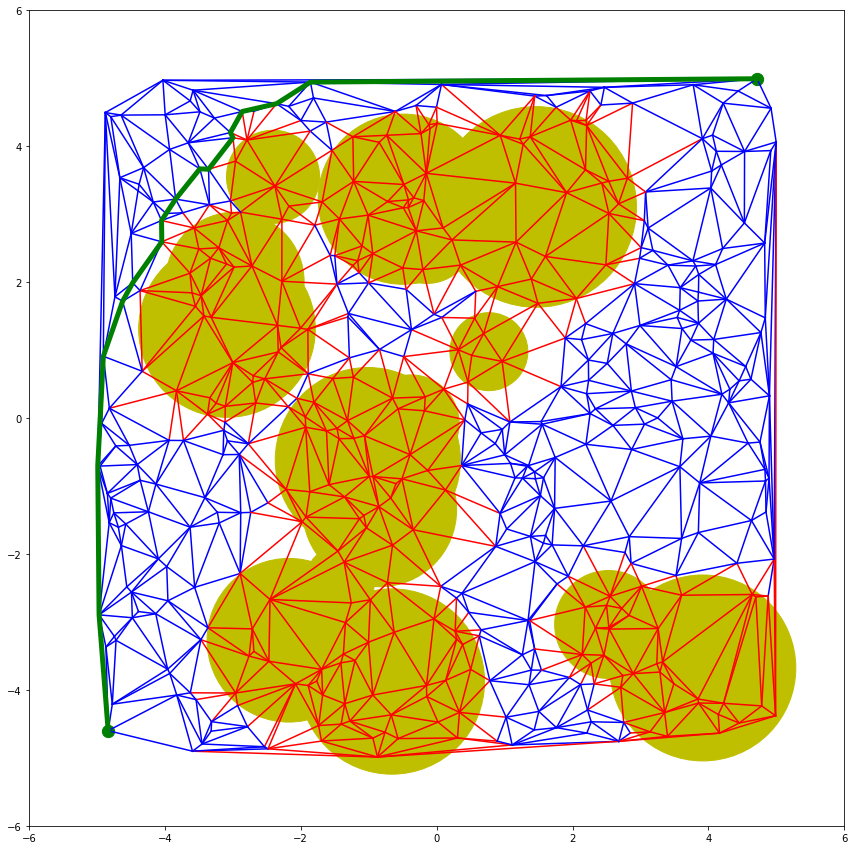

In [57]:
bottomleftindex = -1
bottomleftdist = 1e15
toprightindex = -1
toprightdist = 1e15

bottomleft = np.array([-6,-6])
topright = np.array([6,6])

for i in range(wsmap.size):
    
    if (np.linalg.norm(bottomleft - wsmap.vertices[:,i]) < bottomleftdist):
        
        bottomleftindex = i
        bottomleftdist = np.linalg.norm(bottomleft - wsmap.vertices[:,i])
        
    if (np.linalg.norm(topright - wsmap.vertices[:,i]) < toprightdist):
        
        toprightindex = i
        toprightdist = np.linalg.norm(topright - wsmap.vertices[:,i])
                
path = wsmap.find_path(bottomleftindex, toprightindex)
        
wsmap.plot(path, bottomleftindex, toprightindex)

We're still missing the best part of using a PRM, which is that we can find paths between any two points in the space. The following code demonstrates this; every time we run the code, a random start and end point is selected and solved.

In [63]:
start = np.random.randint(0, wsmap.size)
end = np.random.randint(0, wsmap.size)

while(wsmap.vertices_active[start] == 0):
    
    start = np.random.randint(0, wsmap.size)
    
while(wsmap.vertices_active[end] == 0 or start == end):
    
    end = np.random.randint(0, wsmap.size)
    
path = wsmap.find_path(start, end)
        
wsmap.plot(path, start, end)